In [1]:
# Import packages
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        0.1.0      ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.4 
✔ modeldata    0.1.1      ✔ workflowsets 0.1.0 
✔ parsnip      0.2.0      ✔ yardstick    0.0.9 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks

In [2]:
# Read csv file
# Source: https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_data <- read_csv('https://raw.githubusercontent.com/iaujla01/DSCI100Project/main/data/HTRU_2.csv', col_names = FALSE)

# Adding column names: 
# 1. Mean of the integrated profile
# 2. Standard deviation of the integrated profile
# 3. Excess kurtosis of the integrated profile 
# 4. Skewness of the integrated profile
# 5. Mean of the DM-SNR curve
# 6. Standard deviation of the DM-SNR curve
# 7. Excess kurtosis of the DM-SNR curve
# 8. Skewness of the DM-SNR curve
# 9. Class
colnames(htru_data) <- c('mean_ip', 'sd_ip', 'kurtosis_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr', 'kurtosis_dmsnr', 'skew_dmsnr', 'class')
htru_data <- htru_data %>% 
    mutate(class = as.factor(class)) # since class is a dummy variable that is either positive (1) or negative (0)
head(htru_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip,sd_ip,kurtosis_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [3]:
# 17,898 total examples; 1,639 positive examples; 16,259 negative examples
# Decide to split dataset into 75% training and 25% testing

htru_split <- initial_split(htru_data, prop = 0.75, strata = class)
htru_train <- training(htru_split)
htru_test <- testing(htru_split)

glimpse(htru_train)
glimpse(htru_test)

Rows: 13,423
Columns: 9
$ mean_ip        <dbl> 140.56250, 102.50781, 103.01562, 136.75000, 88.72656, 9…
$ sd_ip          <dbl> 55.68378, 58.88243, 39.34165, 57.17845, 40.67223, 46.69…
$ kurtosis_ip    <dbl> -0.234571412, 0.465318154, 0.323328365, -0.068414638, 0…
$ skew_ip        <dbl> -0.69964840, -0.51508791, 1.05116443, -0.63623837, 1.12…
$ mean_dmsnr     <dbl> 3.1998328, 1.6772575, 3.1212375, 3.6429766, 1.1789298, …
$ sd_dmsnr       <dbl> 19.110426, 14.860146, 21.744669, 20.959280, 11.468720, …
$ kurtosis_dmsnr <dbl> 7.975532, 10.576487, 7.735822, 6.896499, 14.269573, 10.…
$ skew_dmsnr     <dbl> 74.24222, 127.39358, 63.17191, 53.59366, 252.56731, 131…
$ class          <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1…
Rows: 4,475
Columns: 9
$ mean_ip        <dbl> 117.94531, 105.44531, 95.86719, 117.36719, 106.64844, 1…
$ sd_ip          <dbl> 45.50658, 41.13997, 42.05992, 53.90861, 56.36718, 49.69…
$ kurtosis_ip    <dbl> 0.32543756, 0.14265380, 0.32638692, 0.25795344, 0.

In [4]:
set.seed(3456)  

htru_tune <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) %>%
                              set_engine("kknn") %>%
                              set_mode("classification")

htru_recipe <- recipe(class ~. , data = htru_train)%>%
               step_scale(all_predictors()) %>%
               step_center(all_predictors())

In [5]:
set.seed(3456)  
htru_vfold <- vfold_cv(htru_train, v = 5, strata = class)
# Have tried more folds, but no statically significant results 
gridvals <- tibble(neighbors = 1:14) # Picked 14 neighbors to test (inadequate computer power to test more)
htru_results <- workflow() %>%
                add_recipe(htru_recipe) %>%
                add_model(htru_tune) %>%
                tune_grid(resamples = htru_vfold, grid = gridvals) %>%
                collect_metrics()

htru_results

accuracies <- htru_results %>% 
       filter(.metric == "accuracy")

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9686357,5,0.0013464474,Preprocessor1_Model01
1,roc_auc,binary,0.9068669,5,0.0043477952,Preprocessor1_Model01
2,accuracy,binary,0.9686357,5,0.0013464474,Preprocessor1_Model02
2,roc_auc,binary,0.9321547,5,0.0035487415,Preprocessor1_Model02
3,accuracy,binary,0.9769799,5,0.0003966677,Preprocessor1_Model03
3,roc_auc,binary,0.9423708,5,0.0034189829,Preprocessor1_Model03
4,accuracy,binary,0.9769799,5,0.0003966677,Preprocessor1_Model04
4,roc_auc,binary,0.9448506,5,0.0023183635,Preprocessor1_Model04
5,accuracy,binary,0.9782463,5,0.0005477947,Preprocessor1_Model05


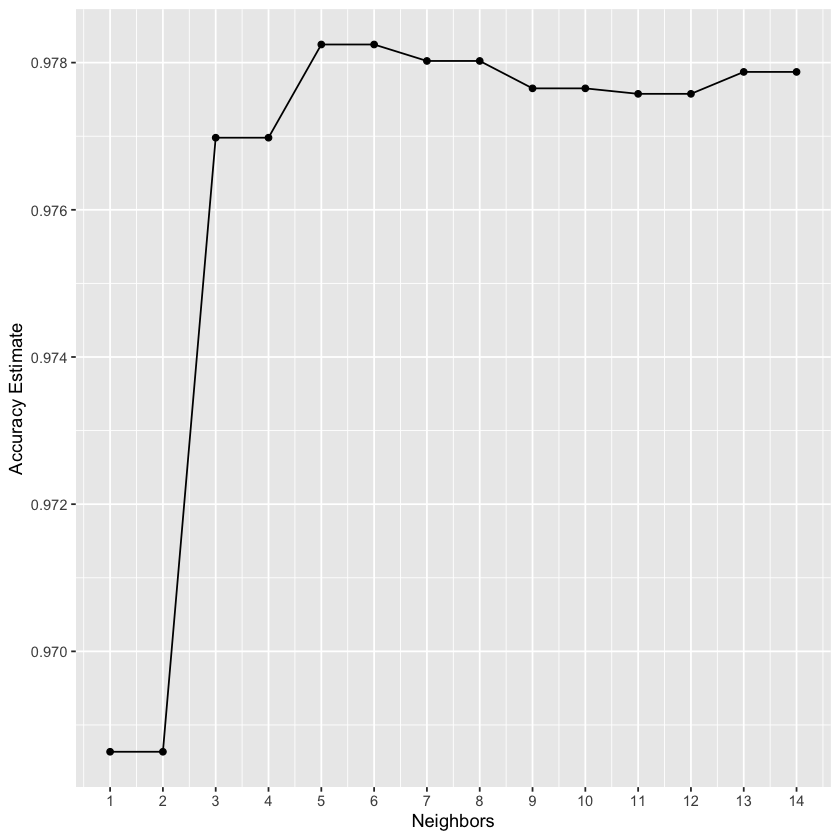

In [6]:
set.seed(3456)  
cross_val_plot  <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1))

cross_val_plot 

In [7]:
set.seed(3456)  
htru_max <- htru_results %>%
  filter(mean == max(mean))

htru_max

htru_max_number <- htru_max %>%
                   slice(1) %>%
                   pull(neighbors)%>%
                   as.integer()

htru_spec_max <- nearest_neighbor(weight_func = "rectangular", neighbors = htru_max_number) %>%
  set_engine("kknn") %>%
  set_mode("classification")

htru_fit <- workflow() %>%
  add_recipe(htru_recipe) %>%
  add_model(htru_spec_max) %>%
  fit(data = htru_train)

htru_summary <- htru_fit %>%
  predict(htru_test) %>%
  bind_cols(htru_test) %>%
  metrics(truth = class, estimate = .pred_class) %>%
  filter(.metric == 'accuracy')

htru_summary

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.9782463,5,0.0005477947,Preprocessor1_Model05
6,accuracy,binary,0.9782463,5,0.0005477947,Preprocessor1_Model06


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9792179


In [ ]:
source('cleanup.R')